<a href="https://colab.research.google.com/github/nikitamahajan92/CodeClauseInternship_Breast_Cancer_Classification_DeepLearning/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Datasets](https://www.kaggle.com/paultimothymooney/breast-histopathology-images/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Replace 'your_file.zip' with the actual file name
file_path = '/content/drive/MyDrive/Breast Cancer Detection using Deep Learning/archive.zip'

# Open the zip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()

print("File extracted successfully.")

File extracted successfully.


In [ ]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [9]:
data = '/content/10262'
No_breast_cancer = '/content/10262/0'
Yes_breast_cancer = '/content/10262/1'

In [11]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1807    labels:  1807


In [13]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1807,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/10262/0/10262_idx5_x201_y801_class0.png,No
1,/content/10262/0/10262_idx5_x801_y601_class0.png,No
2,/content/10262/0/10262_idx5_x2451_y1251_class0...,No
3,/content/10262/0/10262_idx5_x2201_y1001_class0...,No
4,/content/10262/0/10262_idx5_x2051_y2101_class0...,No


In [15]:
print(df['labels'].value_counts())

No     1053
Yes     754
Name: labels, dtype: int64


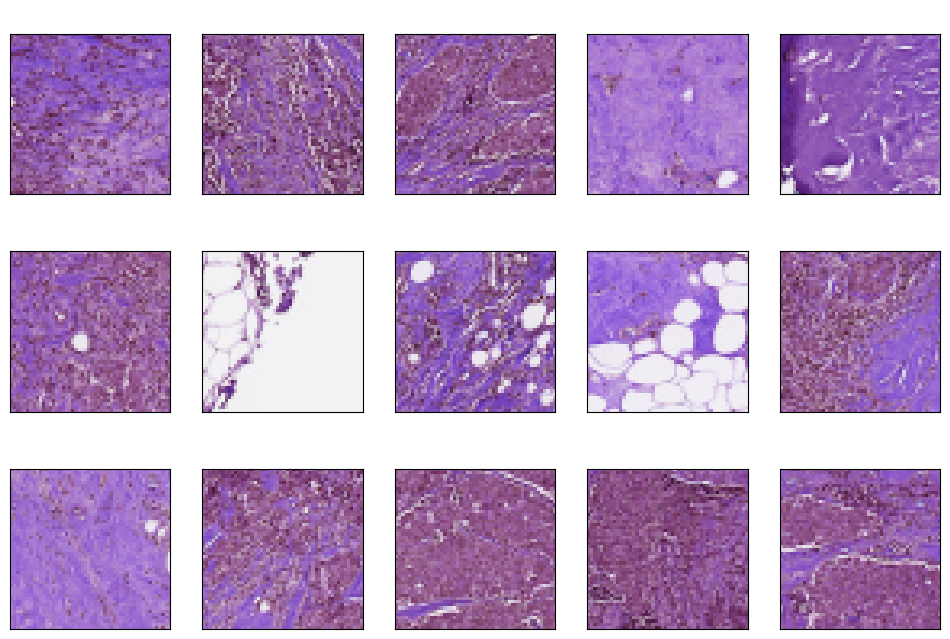

In [16]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (1544, 2)
test set shape: (91, 2)
validation set shape: (172, 2)


In [18]:

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [19]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1544 validated image filenames belonging to 2 classes.
Found 172 validated image filenames belonging to 2 classes.
Found 91 validated image filenames belonging to 2 classes.


In [20]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

**Transfer Learning**

In [21]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])

history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
49/49 [==============================] - 62s 1s/step - loss: 0.7541 - accuracy: 0.5583 - val_loss: 0.6406 - val_accuracy: 0.6047
Epoch 2/100
49/49 [==============================] - 28s 569ms/step - loss: 0.6367 - accuracy: 0.6218 - val_loss: 0.6058 - val_accuracy: 0.6512
Epoch 3/100
49/49 [==============================] - 26s 543ms/step - loss: 0.5583 - accuracy: 0.7124 - val_loss: 0.5063 - val_accuracy: 0.8081
Epoch 4/100
49/49 [==============================] - 27s 553ms/step - loss: 0.5156 - accuracy: 0.7506 - val_loss: 0.4754 - val_accuracy: 0.8140
Epoch 5/100
49/49 [==============================] - 30s 613ms/step - loss: 0.4790 - accuracy: 0.7817 - val_loss: 0.4524 - val_accuracy: 0.8081
Epoch 6/100
49/49 [==============================] - 23s 466ms/step - loss: 0.4507 - accuracy: 0.7902 - val_loss: 0.4592 - val_accuracy: 0.7849
Epoch 7/100
49/49 [==============================] - 29s 595ms/step - loss: 0.4363 - accuracy: 0.7973 - val_loss: 0.4084 - val_accuracy: 0.

In [23]:
model.save("model.h5")

**Evaluating the model**

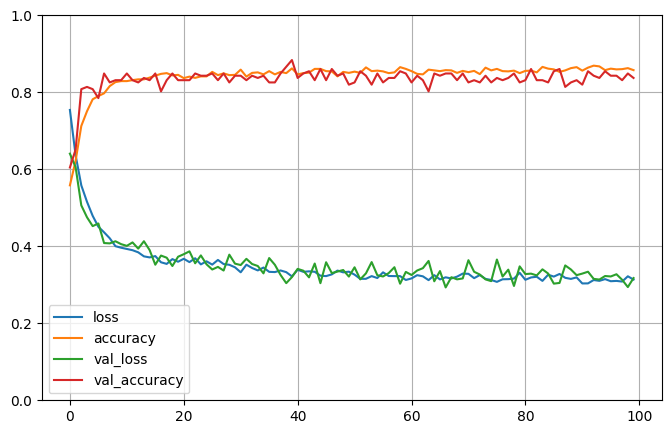

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [35]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/10262/1/10262_idx5_x1201_y1151_class1.png")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")

1/1 [==============================] - 1s 1s/step
Yes


In [36]:
train_gen.class_indices

{'No': 0, 'Yes': 1}